In [1]:
suppressWarnings(library(BayesPrism))
library(tidyverse)

Loading required package: snowfall

Loading required package: snow

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks Bioc

In [2]:
SC.eset <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/All_samples_final_20240707_sub0.08_for_deconv_ExpressionSet.rds')
SC.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 15767 features, 62199 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACCTGCATCACAAC-0_CTCL1_CTCL1_CTCL1
    AAACCTGCATGTAAGA-0_CTCL1_CTCL1_CTCL1 ... GACGTGCTCACATACG-92_S5
    (62199 total)
  varLabels: donor cell_type
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [3]:
sc.dat <- as.matrix(exprs(SC.eset)) %>% t()
dim(sc.dat)

[1] 62199 15767

In [4]:
Bulk.eset <- readRDS('/home/jovyan/farm/CTCL/deconvolution/CTCL-PKU_ExpressionSet.rds') ## CTCL
#Bulk.eset <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/GSE121212_readcount_ExpressionSet.rds') ## healthy skin, AD and psoriasis

Bulk.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 33216 features, 49 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: B266 B355 ... N69 (49 total)
  varLabels: condition
  varMetadata: labelDescription
featureData
  featureNames: METTL25 LINC01742 ... INVS (33216 total)
  fvarLabels: gene_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [5]:
bk.dat <- t(as.matrix(exprs(Bulk.eset)))
dim(bk.dat)

[1]    49 33216

In [6]:
cell.type.labels <- as.vector(phenoData(SC.eset)$cell_type)
cell.state.labels <- as.vector(phenoData(SC.eset)$cell_type)


### Filter outlier genes

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


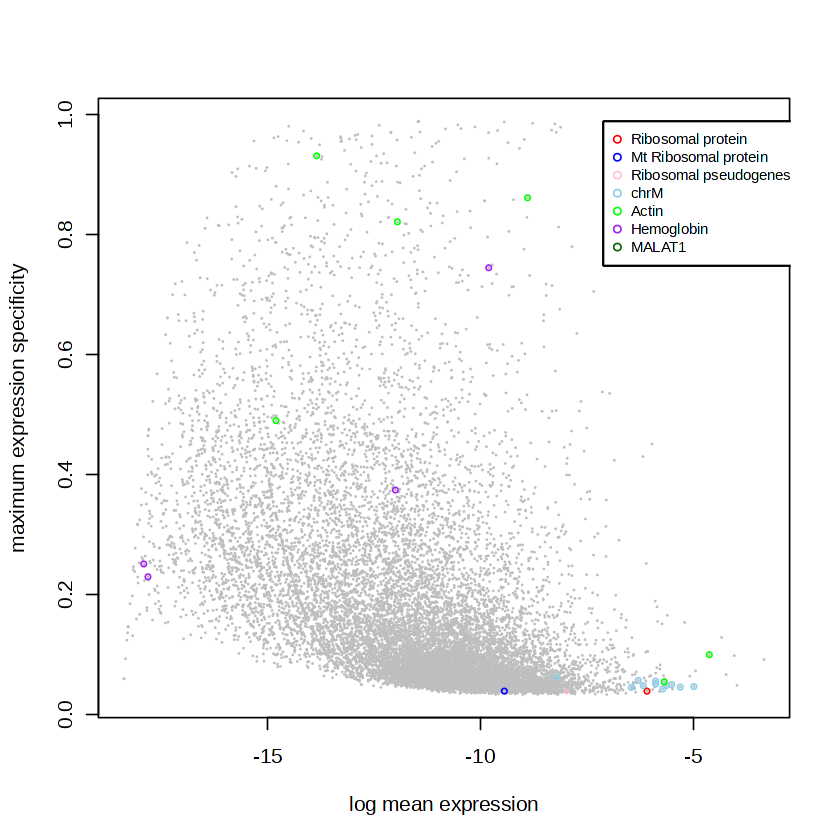

In [7]:
sc.stat <- plot.scRNA.outlier(
  input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE #return the data used for plotting. 
  #pdf.prefix="gbm.sc.stat" specify pdf.prefix if need to output to pdf
)
#> EMSEMBLE IDs detected.


In [8]:
head(sc.stat)  

,exp.mean.log,max.spec,other_Rb,chrM,chrX,chrY,Rb,Mrp,act,hb,MALAT1
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
SAMD11,-14.996691,0.18132875,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NOC2L,-9.976312,0.04265807,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
KLHL17,-12.521347,0.07448819,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
PLEKHN1,-11.946395,0.13014671,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
HES4,-9.980664,0.19117381,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
ISG15,-8.488986,0.10391691,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


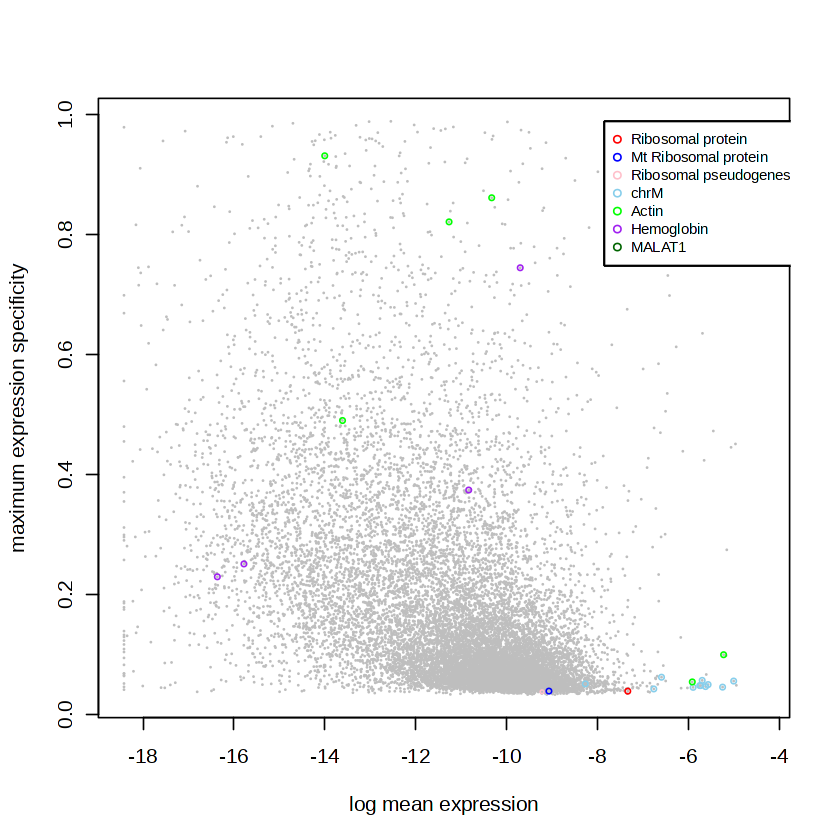

In [9]:
bk.stat <- plot.bulk.outlier(
  bulk.input=bk.dat,#make sure the colnames are gene symbol or ENSMEBL ID 
    sc.input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE
  #pdf.prefix="gbm.bk.stat" specify pdf.prefix if need to output to pdf
)
#> EMSEMBLE IDs detected.

In [10]:
head(bk.stat)

,exp.mean.log,max.spec,other_Rb,chrM,chrX,chrY,Rb,Mrp,act,hb,MALAT1
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
METTL25,-12.06643,0.06561844,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
LINC01742,-18.34815,NA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
CXorf51A,-18.42068,NA,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AC093525.4,-15.21725,NA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
C3orf79,-15.93276,NA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
THOC3,-10.62218,NA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [11]:
sc.dat.filtered <- cleanup.genes (input=sc.dat,
                                  input.type="count.matrix",
                                    species="hs", 
                                    gene.group=c( "Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY") ,
                                    exp.cells=5)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
       1        1        1       11        0      555       30 
A total of  581  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  111  gene expressed in fewer than  5  cells have been excluded 


In [12]:
dim(sc.dat.filtered)

[1] 62199 15075

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


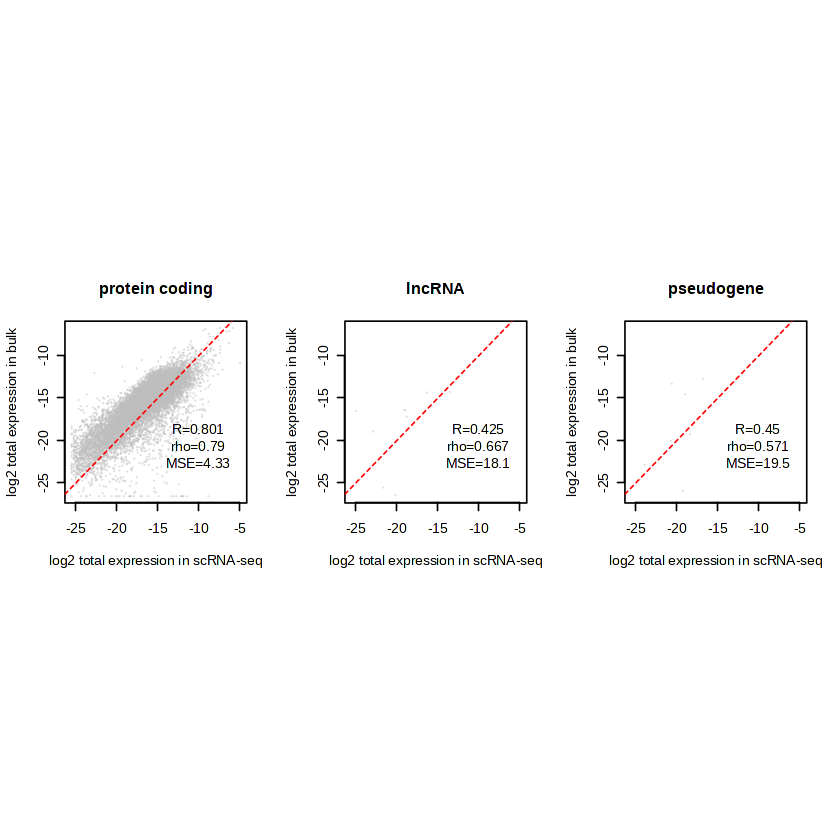

In [13]:
#note this function only works for human data. For other species, you are advised to make plots by yourself.
plot.bulk.vs.sc (sc.input = sc.dat.filtered,
                            bulk.input = bk.dat
                            #pdf.prefix="gbm.bk.vs.sc" specify pdf.prefix if need to output to pdf
)

In [14]:
sc.dat.filtered.pc <-  select.gene.type (sc.dat.filtered,
                                        gene.type = "protein_coding")

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes retained in each category: 

protein_coding 
         14357 


In [15]:

# Select marker genes (Optional)
# performing pair-wise t test for cell states from different cell types

diff.exp.stat <- get.exp.stat(sc.dat=sc.dat[,colSums(sc.dat>0)>3],# filter genes to reduce memory use
                                          cell.type.labels=cell.type.labels,
                                          cell.state.labels=cell.state.labels,
                                          psuedo.count=0.1, #a numeric value used for log2 transformation. =0.1 for 10x data, =10 for smart-seq. Default=0.1.
                                          cell.count.cutoff=50, # a numeric value to exclude cell state with number of cells fewer than this value for t test. Default=50.
                                          n.cores=5 #number of threads
                                          )

In [16]:
sc.dat.filtered.pc.sig <- select.marker (sc.dat=sc.dat.filtered.pc,
                                                  stat=diff.exp.stat,
                                                  pval.max=0.01,
                                                  lfc.min=0.1)

number of markers selected for each cell type: 
Differentiated_KC :  212 
Differentiated_KC* :  319 
moDC_3 :  131 
LC_4 :  72 
Macro_1 :  104 
Undifferentiated_KC :  73 
Proliferating_KC :  334 
Melanocyte :  340 
LC_3 :  41 
F2 :  179 
DC2 :  28 
MigDC :  58 
Th :  4 
Macro_2 :  23 
DC1 :  15 
Inf_mac :  52 
LC_2 :  16 
Treg :  31 
moDC_1 :  12 
Tc17_Th17 :  8 
Tc :  6 
ILC1_NK :  14 
Mono_mac :  49 
F3 :  37 
F1 :  308 
moDC_2 :  35 
B_cell :  116 
NK :  50 
VE2 :  121 
VE1 :  78 
Pericyte_2 :  168 
Pericyte_1 :  42 
pDC :  262 
VE3 :  96 
LE1 :  86 
LE2 :  104 
Schwann_1 :  36 
Plasma :  154 
ILC1_3 :  26 
Tc_IL13_IL22 :  19 
Mast_cell :  39 
LC_1 :  65 
ILC2 :  48 


In [17]:
dim(sc.dat.filtered.pc.sig)

[1] 62199  3719

#### Construct a prism object

In [18]:
myPrism <- new.prism(
  reference=sc.dat.filtered.pc.sig, ### or sc.dat.filtered.pc
  mixture=bk.dat,
  input.type="count.matrix", 
  cell.type.labels = cell.type.labels, 
  cell.state.labels = cell.state.labels,
  key=NULL,
  outlier.cut=0.01,
    outlier.fraction=0.1,
)

number of cells in each cell state 
cell.state.labels
               ILC2           Mast_cell                LC_1                 pDC 
                 68                 142                 143                 251 
          Schwann_1             ILC1_NK                  NK                 LE1 
                288                 295                 342                 372 
            Macro_2                 LE2              ILC1_3                LC_2 
                445                 483                 526                 538 
             moDC_1              Plasma                 DC1           Tc17_Th17 
                553                 565                 638                 668 
               LC_3              moDC_2                LC_4                 VE3 
                686                 694                 738                 743 
             moDC_3             Inf_mac        Tc_IL13_IL22             Macro_1 
                828                 845                

In [19]:
bp.res <- run.prism(prism = myPrism, n.cores=50)

Run Gibbs sampling... 
Current time:  2024-07-09 23:11:16 
Estimated time to complete:  9mins 
Estimated finishing time:  2024-07-09 23:19:20 
Start run... 
R Version:  R version 4.0.4 (2021-02-15) 



snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2024-07-09 23:34:39 
Estimated time to complete:  6mins 
Estimated finishing time:  2024-07-09 23:40:16 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




In [20]:
#bp.res

In [21]:
slotNames(bp.res)

[1] "prism"                       "posterior.initial.cellState"
[3] "posterior.initial.cellType"  "reference.update"           
[5] "posterior.theta_f"           "control_param"

In [22]:
# extract posterior mean of cell type fraction theta
theta <- get.fraction(bp=bp.res,
            which.theta="final",
            state.or.type="type")

head(theta)

,Differentiated_KC,Differentiated_KC*,moDC_3,LC_4,Macro_1,Undifferentiated_KC,Proliferating_KC,Melanocyte,LC_3,F2,⋯,VE3,LE1,LE2,Schwann_1,Plasma,ILC1_3,Tc_IL13_IL22,Mast_cell,LC_1,ILC2
B266,1.692842e-01,3.717327e-02,1.444576e-06,1.065323e-03,1.534671e-06,3.761787e-02,1.275552e-01,1.280633e-02,1.765002e-06,0.14258037,⋯,0.03111046,3.838401e-03,2.751808e-05,1.549406e-05,4.631745e-07,3.330685e-03,5.128780e-05,3.865829e-03,1.818577e-04,3.564123e-02
B355,5.949325e-02,1.815745e-02,1.413851e-06,7.060336e-07,2.869194e-02,4.176757e-03,3.389684e-02,3.674279e-03,2.039901e-06,0.16080591,⋯,0.02887420,7.505059e-03,1.310961e-05,1.271706e-06,1.279804e-06,7.445763e-06,2.660336e-03,6.830092e-04,7.400532e-07,6.169942e-02
B470,8.203103e-02,1.062341e-06,2.418787e-06,2.452801e-06,8.045952e-05,1.397228e-02,1.345399e-06,1.572204e-03,1.899778e-06,0.26390641,⋯,0.03256940,5.639847e-02,1.160284e-06,1.014296e-01,1.762843e-06,3.800065e-06,2.219870e-06,3.249937e-03,4.386431e-07,1.600468e-02
B520-2,3.634483e-02,3.193678e-04,2.559262e-04,5.938112e-07,2.001830e-02,9.521697e-06,3.957468e-03,9.650458e-04,1.149446e-06,0.17955553,⋯,0.01598965,4.718408e-03,5.349835e-03,6.530191e-07,8.834434e-03,5.582809e-06,2.665398e-06,3.268144e-04,3.733382e-07,8.476021e-07
L107,1.044766e-02,7.150941e-04,4.990943e-07,4.437594e-07,1.545168e-01,2.746671e-07,4.543474e-02,3.707763e-03,9.452392e-07,0.08172533,⋯,0.02452236,8.463360e-07,3.309502e-03,4.678544e-07,1.147220e-06,5.777282e-06,9.411494e-04,5.157568e-07,2.334302e-07,7.620648e-07
L112,8.854296e-07,2.005446e-03,1.599069e-06,3.161729e-06,1.503335e-02,6.877401e-07,3.159889e-07,6.156166e-05,6.895624e-07,0.14628568,⋯,0.01837007,1.287591e-04,6.861105e-07,2.849985e-07,1.102841e-01,4.595471e-07,4.066495e-07,6.809028e-07,2.511683e-07,1.842211e-06


In [24]:
saveRDS(bp.res, '/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution_revision/Deconv_PKU_CTCL_integrated_atlas_sub0.08_DEGs.rds')


In [2]:
library(tidyverse)
library(ggbeeswarm)
library(ggplot2)
library(reshape2)
library(SingleCellExperiment)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:lubridate’:

    second, second<-


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand


The following object is masked from ‘package:NMF’:

    nrun


The following object is masked from ‘package:base’:

    expand.grid


Loading required package: IRanges


Attaching package: ‘IRanges’


The following object is masked from ‘package:lubridate’:

    %within%


The following objects are masked from ‘package:dplyr’:

    collapse, desc, slice


The following object is masked from ‘package:purrr’:

    reduce


Loading required package: GenomeInfoDb

Loading require

In [3]:
E_1 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution_revision/Deconv_GSE121212_integrated_atlas_sub0.08_DEGs.rds')
E_2 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution_revision/Deconv_PKU_CTCL_integrated_atlas_sub0.08_DEGs.rds')

In [4]:
Est_1 <- get.fraction(bp=E_1,
            which.theta="final",
            state.or.type="type")

head(Est_1)

,Differentiated_KC,Differentiated_KC*,moDC_3,LC_4,Macro_1,Undifferentiated_KC,Proliferating_KC,Melanocyte,LC_3,F2,⋯,VE3,LE1,LE2,Schwann_1,Plasma,ILC1_3,Tc_IL13_IL22,Mast_cell,LC_1,ILC2
AD_004_lesional,0.3662774,1.312058e-01,6.708646e-06,3.717296e-05,5.825453e-06,0.1264446,1.362556e-01,0.03576886,2.406624e-05,0.05135181,⋯,0.006611646,0.0006732736,1.490668e-05,4.785050e-06,3.931336e-05,3.819873e-05,3.408602e-04,9.439077e-05,0.0026323934,2.451205e-05
AD_004_non-lesional,0.3928262,2.618265e-05,5.599674e-06,7.574573e-06,4.370968e-06,0.3480040,2.652032e-06,0.05840978,7.400578e-06,0.06487322,⋯,0.007615818,0.0014346038,5.418886e-06,1.005671e-04,7.588047e-06,4.423925e-06,6.037044e-06,5.801191e-04,0.0022752372,2.733273e-02
AD_005_lesional,0.2981762,1.670936e-01,8.054659e-06,4.750676e-06,8.532281e-04,0.1403595,4.370058e-02,0.02417716,3.859848e-06,0.15608005,⋯,0.016135699,0.0002477471,4.129286e-06,1.264421e-05,4.137557e-05,2.131812e-03,8.699981e-04,1.008517e-03,0.0005743516,7.851201e-06
AD_005_non-lesional,0.3530325,6.536929e-06,2.192481e-06,2.695390e-06,5.496937e-06,0.3167838,1.605605e-06,0.03278031,3.072384e-06,0.09316595,⋯,0.020312463,0.0033077567,2.795274e-06,2.254781e-03,6.595185e-05,5.327391e-06,2.034712e-06,3.656972e-04,0.0006699619,1.318961e-02
AD_006_lesional,0.4528607,2.935955e-02,1.501790e-05,6.346779e-06,1.954708e-06,0.1949189,1.193779e-01,0.05485220,2.218465e-05,0.03997333,⋯,0.009385504,0.0005699245,3.642753e-06,5.771500e-06,3.161496e-05,1.697844e-04,9.411062e-05,7.977671e-04,0.0017514416,7.415854e-03
AD_006_non-lesional,0.3455872,5.456890e-02,1.788298e-05,1.191249e-05,1.974307e-06,0.3673857,4.309040e-06,0.05119204,9.346593e-06,0.02979362,⋯,0.006644234,0.0003762136,9.238728e-06,1.684819e-05,8.784318e-06,8.974975e-05,4.714525e-06,2.745374e-04,0.0038684147,2.091884e-02


In [5]:
Est_2 <- get.fraction(bp=E_2,
            which.theta="final",
            state.or.type="type")

head(Est_2)

,Differentiated_KC,Differentiated_KC*,moDC_3,LC_4,Macro_1,Undifferentiated_KC,Proliferating_KC,Melanocyte,LC_3,F2,⋯,VE3,LE1,LE2,Schwann_1,Plasma,ILC1_3,Tc_IL13_IL22,Mast_cell,LC_1,ILC2
B266,2.119718e-01,1.869809e-05,1.481410e-06,7.658318e-07,7.257234e-07,7.556713e-02,1.903390e-01,0.0159757319,3.314782e-06,0.1881469,⋯,0.03539100,2.312857e-03,4.641601e-06,3.555179e-05,1.207942e-06,3.600180e-03,5.198690e-04,4.405171e-03,8.544995e-04,2.671364e-02
B355,9.106552e-02,1.621260e-03,3.461984e-04,2.997907e-03,8.906580e-06,1.993940e-02,6.125457e-02,0.0063235624,5.876288e-04,0.2382639,⋯,0.03721784,5.303112e-03,1.042526e-05,2.844381e-06,3.189285e-06,9.463511e-06,3.034060e-06,1.469652e-03,4.696655e-06,3.899728e-02
B470,1.150666e-01,1.280582e-06,1.556115e-05,8.515041e-07,1.670884e-06,2.585818e-02,2.282728e-06,0.0042571398,1.840257e-06,0.3929611,⋯,0.07294282,6.008507e-03,3.231595e-06,5.908072e-02,1.934001e-06,8.209818e-06,3.404187e-06,4.869677e-03,5.563309e-04,2.765005e-02
B520-2,5.904629e-02,9.934859e-04,3.725731e-03,7.201635e-06,6.349614e-03,3.325745e-04,1.308342e-02,0.0023159478,4.162887e-06,0.2931459,⋯,0.02803347,3.036215e-04,1.129700e-02,1.532545e-06,3.737218e-06,2.311230e-05,1.320988e-06,1.459503e-03,1.603522e-06,2.363279e-06
L107,2.750736e-02,4.415304e-04,1.254391e-06,9.077557e-07,1.893694e-01,9.731948e-07,4.188229e-02,0.0020695576,1.665907e-06,0.1190852,⋯,0.03914342,6.637037e-05,7.999864e-04,9.310216e-05,1.118049e-05,2.658599e-06,2.111217e-06,7.390989e-07,6.563166e-07,1.362055e-06
L112,3.701065e-06,7.517329e-03,2.140816e-06,6.988287e-03,1.848110e-03,8.818755e-07,1.473319e-06,0.0002744663,2.879326e-06,0.2697724,⋯,0.03078808,2.115682e-04,1.994231e-06,1.161065e-06,1.124091e-01,3.240436e-06,2.350791e-06,5.862010e-06,8.544899e-07,3.234881e-06


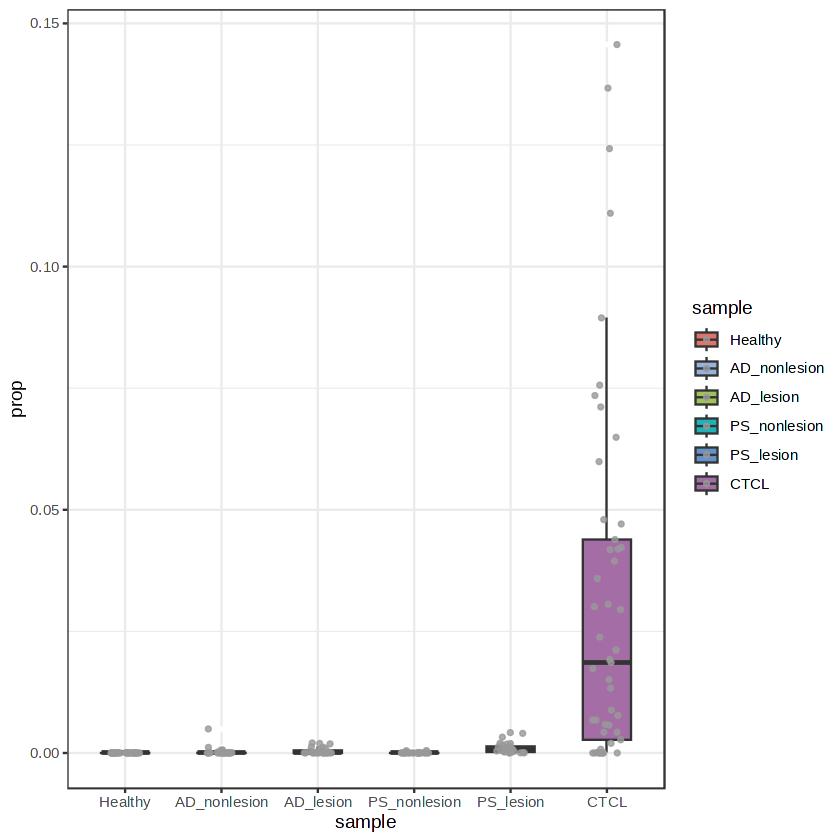

In [37]:
celltype <- "B_cell"
Est_1_B <- data.frame(prop = Est_1[, celltype], sample = "Healthy")
Est_1_B[grep('^AD.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_nonlesion'
Est_1_B[grep('^AD.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^AD.*_chronic_lesion$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^PSO.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_nonlesion'
Est_1_B[grep('^PSO.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_lesion'


#celltype <- "B/plasma"
Est_2_B <- data.frame(prop = Est_2[, celltype], sample = "CTCL")

Est <- rbind(Est_1_B, Est_2_B)
Est$sample <- factor(Est$sample, levels = c('Healthy', 'AD_nonlesion', 'AD_lesion',
                                            'PS_nonlesion', 'PS_lesion','CTCL'))

ggplot(data = Est,aes(x = sample, y = prop, fill = sample))+
  geom_boxplot(aes(group=sample), width=0.5, outlier.colour = "white", outlier.size = 0.5)+
  geom_point(position=position_jitter(width = 0.15,height = 0),alpha=0.8,shape=19, color = 'grey60', size = 1)+
  #geom_quasirandom(method = "quasirandom", dodge.width=0.8, size=1.2, shape=20, alpha=1) +
  scale_fill_manual(values = c("#E07469","#97B2DD", "#A1C15F","#1CB4B8", "#6692CC","#A46DA6")) +
theme_bw()

#ggsave('./figures/Decov_moDC3.pdf', width = 6, height = 5)

In [42]:
c1 <- Est$prop[which(Est$sample == "CTCL")]
c2 <- Est$prop[which(Est$sample == "Healthy")]

wilcox.test(c1,c2)


	Wilcoxon rank sum exact test

data:  c1 and c2
W = 1549, p-value = 2.468e-08
alternative hypothesis: true location shift is not equal to 0


### Prognostic data

In [63]:
data <- read.table("/home/jovyan/farm/CTCL/deconvolution/PKU_metadata_PFS_OS.xls", header = T)
data <- data[,1:9]

In [64]:
data %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,B266,F,70,no,IIB,55,1,56,1
2,B355,M,55,LCT,IIB,10,1,10,1
3,B470,M,45,no,IIB,32,0,32,0
4,L107,M,52,LCT,IIB,12,0,12,0
5,L112,M,21,LCT,IIB,4,1,22,1
6,L149,F,15,LCT,IIB,24,1,54,1


In [65]:
E_2 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution_revision/Deconv_PKU_CTCL_integrated_atlas_sub0.08_DEGs.rds')

Est_2 <- get.fraction(bp=E_2,
            which.theta="final",
            state.or.type="type")

In [66]:
Est_2 <- Est_2[-which(rownames(Est_2)=='B520-2'), c('B_cell', 'VE2')] ## remove a replecate sample (B520-2 and B520)
dim(Est_2)

[1] 48  2

In [67]:
data_prop <- cbind(data, Est_2)
data_prop <- data_prop[,-ncol(data_prop)]
data_prop %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS,B_cell
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>
B266,B266,F,70,no,IIB,55,1,56,1,3.082533e-06
B355,B355,M,55,LCT,IIB,10,1,10,1,1.736493e-02
B470,B470,M,45,no,IIB,32,0,32,0,7.869920e-04
L107,L107,M,52,LCT,IIB,12,0,12,0,3.459299e-06
L112,L112,M,21,LCT,IIB,4,1,22,1,4.708281e-02
L149,L149,F,15,LCT,IIB,24,1,54,1,1.366941e-01


In [68]:
colnames(data_prop) <- c(colnames(data_prop)[1:9],'B_cell')

In [69]:
colnames(data_prop)

[1] "Patient"  "Sex"      "Age"      "LCT"      "Stage"    "PFS_time"
 [7] "PFS"      "OS_time"  "OS"       "B_cell"

In [70]:
library(survival)
library(survminer)
library(survMisc)
library(RColorBrewer)

In [71]:
cut <- cutp(coxph(Surv(PFS_time, PFS)~Stage+Age+strata(Sex) + B_cell, data=data_prop))$B_cell[]
cut %>% head()

B_cell,U,Q,p
<dbl>,<dbl>,<dbl>,<dbl>
0.04193070,5.654528,1.3214838,0.06083927
0.04179684,5.018267,1.1727873,0.12771251
0.04226829,4.762844,1.1130939,0.16772999
0.03056213,4.567278,1.0673895,0.20462660
0.03946654,4.382006,1.0240908,0.24506581
0.00771534,4.231038,0.9888089,0.28218967


In [72]:
data_prop$tx <- rep(NA, nrow(data_prop))
data_prop$tx[which(data_prop$B_cell < 0.04193070)] <- 1
#data$tx[which(data$B_plasma >= 0.027831 & data$B_plasma < 0.094703)] <- 2
data_prop$tx[which(data_prop$B_cell >= 0.04193070)] <- 2

In [73]:
data_prop %>% head

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS,B_cell,tx
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
B266,B266,F,70,no,IIB,55,1,56,1,3.082533e-06,1
B355,B355,M,55,LCT,IIB,10,1,10,1,1.736493e-02,1
B470,B470,M,45,no,IIB,32,0,32,0,7.869920e-04,1
L107,L107,M,52,LCT,IIB,12,0,12,0,3.459299e-06,1
L112,L112,M,21,LCT,IIB,4,1,22,1,4.708281e-02,2
L149,L149,F,15,LCT,IIB,24,1,54,1,1.366941e-01,2


In [76]:
data_prop$tx %>% table

.
 1  2 
34 14 

[1] 34

[1] 14

Call:
coxph(formula = Surv(PFS_time, as.numeric(PFS)) ~ tx + Stage + 
    Age + strata(Sex), data = data_prop)

  n= 48, number of events= 22 

             coef exp(coef) se(coef)     z Pr(>|z|)  
tx        1.06538   2.90195  0.51759 2.058   0.0396 *
StageIIIA 0.34140   1.40691  1.10156 0.310   0.7566  
StageIIIB 0.25089   1.28518  1.06413 0.236   0.8136  
StageIVA2 0.87647   2.40240  0.66078 1.326   0.1847  
StageIVB  1.06860   2.91130  1.08472 0.985   0.3246  
Age       0.01358   1.01367  0.01481 0.917   0.3590  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
tx            2.902     0.3446    1.0522     8.003
StageIIIA     1.407     0.7108    0.1624    12.188
StageIIIB     1.285     0.7781    0.1597    10.345
StageIVA2     2.402     0.4163    0.6579     8.772
StageIVB      2.911     0.3435    0.3474    24.401
Age           1.014     0.9865    0.9847     1.044

Concordance= 0.704  (se = 0.06 )
Likelihood ratio te

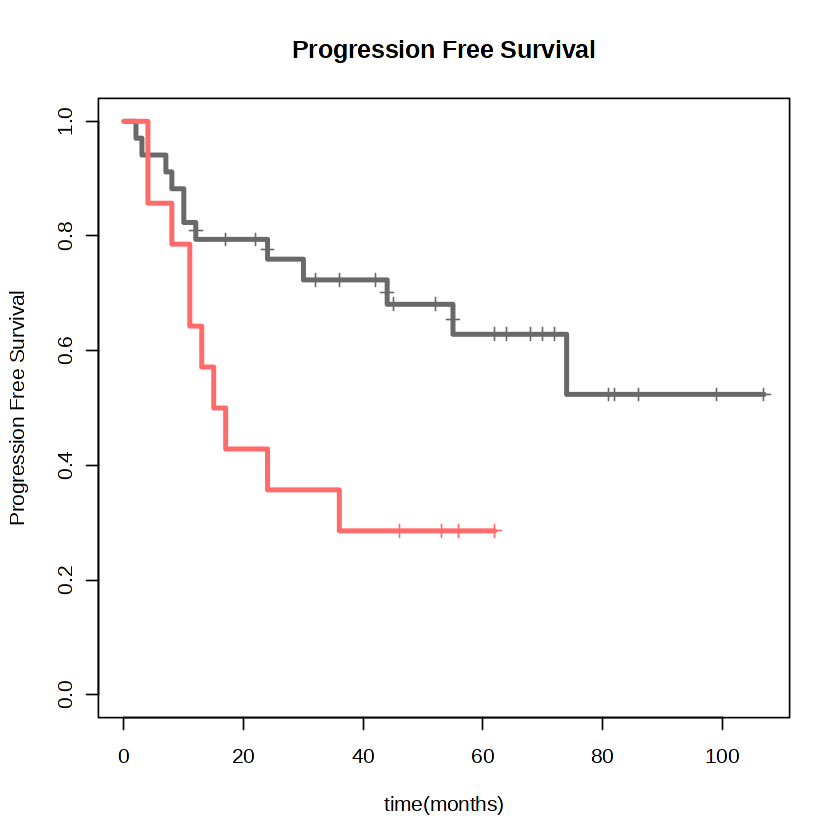

In [74]:
sd <- survfit(Surv(PFS_time, as.numeric(PFS))~tx, data=data_prop, se.fit=T, conf.int=.95,type="kaplan-meier")
#ggsurvplot(sd, data=data, conf.int = TRUE, palette = c("dodgerblue3","red2"))

SD <- coxph(Surv(PFS_time,as.numeric(PFS))~tx+Stage+Age+strata(Sex),data=data_prop)
plot(sd, lty=1, lwd=3, col=c("DimGrey", "IndianRed1"),
     mark.time=T, xlab="time(months)",ylab="Progression Free Survival",main="Progression Free Survival")

sum(data_prop$tx==1)
sum(data_prop$tx==2)

summary(SD)

In [75]:
pdf("./figures/Bcell_prognosis_new.pdf", w=5, h=6)
plot(sd, lty=1, lwd=3, col=c("DimGrey", "IndianRed1"),
     mark.time=T, xlab="time(months)",ylab="Progression Free Survival",main="Progression Free Survival")
dev.off()

png 
  2